In [1]:
import xmltodict, collections, cv2
import numpy as np
import matplotlib.pyplot as plt

C:\Users\duran\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\duran\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\duran\anaconda3\lib\site-packages\numpy\.libs\libopenblas.wcdjnk7yvmpzq2me2zzhjjrj3jikndb7.gfortran-win_amd64.dll
C:\Users\duran\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [6]:

def parse_dict(path):
    x = xmltodict.parse(open(path, 'r').read())
    task_name = x['annotations']['meta']['task']['name']
    video_name = 'none'

    tracks = []
    if not 'track' in x['annotations']:
        return
    if isinstance(x['annotations']['track'], collections.OrderedDict):
        track_list = [x['annotations']['track']]
    elif isinstance(x['annotations']['track'], list):
        track_list = x['annotations']['track']

    for i in track_list:
        label = i['@label']

        frames = {}
        if 'polygon' in i.keys():
            if isinstance(i['polygon'], collections.OrderedDict):
                poly_list = [i['polygon']]
            elif isinstance(i['polygon'], list):
                poly_list = i['polygon']
            for j in poly_list:
                frame = j['@frame']
                outside = int(j['@outside'])
                if outside==1:
                    continue
                points = np.array([
                                 [q.split(',') for q in j['@points'].split(';')]
                ], 'float32')
                frames[frame] = {'points': points, 'subclass': 'none'}
            tracks.append([{'label':label, 'frames':frames, 'type': 'polygon'}])

        elif 'points' in i.keys():
            if isinstance(i['points'], collections.OrderedDict):
                points_list = [i['points']]
            elif isinstance(i['points'], list):
                points_list = i['points']
            for j in points_list:
                frame = j['@frame']
                outside = int(j['@outside'])
                if outside==1:
                    continue
                points = np.array([
                                 [q.split(',') for q in j['@points'].split(';')]
                ], 'float32')
                point_id = j['attribute']['#text'] if 'attribute' in j.keys() else 'none'
                frames[frame] = {'points': points, 'subclass': point_id}
            tracks.append([{'label':label, 'frames':frames, 'type': 'points'}])

        elif 'polyline' in i.keys():
            if isinstance(i['polyline'], collections.OrderedDict):
                points_list = [i['polyline']]
            elif isinstance(i['polyline'], list):
                points_list = i['polyline']
            for j in points_list:
                frame = j['@frame']
                outside = int(j['@outside'])
                if outside==1:
                    continue
                points = np.array([
                                 [q.split(',') for q in j['@points'].split(';')]
                ], 'float32')
                frames[frame] = {'points': points, 'subclass': 'none'}
            tracks.append([{'label':label, 'frames':frames, 'type': 'polyline'}])

        else:
            pass

    return {
      'task_name':task_name,
      'video_name':video_name,
      'tracks':tracks
    }


def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1]) #Typo was here

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
      #  raise Exception('lines do not intersect')
      return 0,0

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def create_line(p1, p2):
    """
    Получаем прямую, проходящую через 2 точки
    params: two tuples (int)
    return: координаты прямой
    """
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0] * p2[1] - p2[0] * p1[1])
    return A, B, C

def calc_line(p1,p2, x1, x2):
    A,B,C = create_line(p1, p2)
def f(x):
    return (-C - A*x) / B
    return f(x1), f(x2)

def get_dots_for_verticals_and_sectors(verticals, sectors):
    dots=[]
    for v in verticals:
        for i in range(len(v)-1):
            line = [v[i], v[i+1]]
            for s in sectors:
                x,y = line_intersection(line, s)
                if x<=max(line[0][0],line[1][0]) and x>=min(line[0][0],line[1][0]) \
                      and y<=max(line[0][1],line[1][1]) and y>=min(line[0][1],line[1][1]) or \
                      abs(x-max(line[0][0],line[1][0])) < 5 and abs(y-max(line[0][1],line[1][1])) < 5 or \
                       abs(x-min(line[0][0],line[1][0])) < 5 and abs(y-min(line[0][1],line[1][1])) < 5 :
                    dots.append([x,y])
    return dots_delete_duples(dots)

def dots_delete_duples(dots):
    newj = []
    for k in dots:
        if k[0]==0 and k[1]==0:
            isin=True
            break
        isin=False
        for k2 in newj:
            dist = np.sqrt(
              (k[0]-k2[0])**2 + (k[1]-k2[1])**2
          )
            if dist<3:
                isin = True
                break
        if not isin:
            newj.append(k)
        return newj

In [7]:
data = parse_dict('../annots/task_kate_evraz_cam14_0530_0730_20211110-080000--20211110-083000-2021_11_15_07_26_01-cvat for video 1.1/annotations.xml')

In [8]:
data

{'task_name': 'kate_evraz_cam14_0530_0730_20211110-080000--20211110-083000',
 'video_name': 'none',
 'tracks': [[{'label': 'left_chain',
    'frames': {'40': {'points': array([[[1214.44, 1015.39],
              [1141.9 ,  744.46],
              [1112.14,  631.79],
              [1091.12,  563.91],
              [1080.09,  527.79]]], dtype=float32),
      'subclass': 'none'}},
    'type': 'polyline'}],
  [{'label': 'zigzag',
    'frames': {'40': {'points': array([[[1151.31,  992.58],
              [1304.99,  992.58],
              [1131.77,  863.77],
              [1258.8 ,  869.99],
              [1111.96,  754.69],
              [1208.08,  761.35],
              [1096.86,  686.56],
              [1184.  ,  688.96],
              [1087.  ,  635.13],
              [1164.73,  642.85],
              [1079.63,  600.57],
              [1147.41,  605.1 ],
              [1074.3 ,  571.7 ],
              [1131.15,  572.41],
              [1068.88,  547.81],
              [1120.4 ,  549.05],
  

In [23]:

data

{'task_name': 'kate_evraz_cam14_0530_0730_20211110-080000--20211110-083000',
 'video_name': 'none',
 'tracks': [[{'label': 'left_chain',
    'frames': {'40': {'points': array([[[1214.44, 1015.39],
              [1141.9 ,  744.46],
              [1112.14,  631.79],
              [1091.12,  563.91],
              [1080.09,  527.79]]], dtype=float32),
      'subclass': 'none'}},
    'type': 'polyline'}],
  [{'label': 'zigzag',
    'frames': {'40': {'points': array([[[1151.31,  992.58],
              [1304.99,  992.58],
              [1131.77,  863.77],
              [1258.8 ,  869.99],
              [1111.96,  754.69],
              [1208.08,  761.35],
              [1096.86,  686.56],
              [1184.  ,  688.96],
              [1087.  ,  635.13],
              [1164.73,  642.85],
              [1079.63,  600.57],
              [1147.41,  605.1 ],
              [1074.3 ,  571.7 ],
              [1131.15,  572.41],
              [1068.88,  547.81],
              [1120.4 ,  549.05],
  

In [24]:
frames = {}
for tracks in data['tracks']:
  for track in tracks:
    for fr_id, d in track['frames'].items():
      fr_id = int(fr_id)
      if fr_id not in frames.keys():
        frames[fr_id] = {track['label']: {'points': d['points'], 'type': track['type']}}
      else:
        frames[fr_id][track['label']] = {'points': d['points'], 'type': track['type']}

gt_data = {}

for frame_id, frame in frames.items():
  try:
    lc = frame['left_chain']['points'][0]
    rc = frame['right_chain']['points'][0]
    z = frame['zigzag']['points'][0]
    verticals = [lc,rc]
    sectors = []
    for i in z.reshape(-1, 4):
      sectors.append([[i[0],i[1]], [i[2],i[3]]])

    dots = get_dots_for_verticals_and_sectors(verticals, sectors)
    dots = np.array(list(z) + dots)

    gt_data[frame_id] = dots
    # break
  except:
    print(frame_id) # invalid annotation

2104


In [25]:

def display_dots(image, arr, radius=3, color=(255,0,0), thickness=-1):
  for x,y in arr:
      image = cv2.circle(image,
                         (int(round(x)), int(round(y))), radius, color, thickness)
  return image

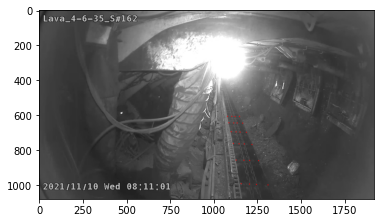

In [26]:
vid = cv2.VideoCapture('../videos/1/нарезанные/camera14/camera14-20211110-080000--20211110-083000_time_05-30_07-30.mp4')

for i in range(int(vid.get(cv2.CAP_PROP_FRAME_COUNT))):
    return_value, frame = vid.read()
    if not return_value:
        print('finish')
        break
    image = np.array(frame.copy())
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = display_dots(image, gt_data[i])
    plt.imshow(image)
    plt.show()
    break